## Loading Data

In [0]:
import os
import uuid 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import warnings
warnings. filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/cabspottingdata'
txt_file_names = os.listdir(data_path)

taxi_dfs = []

for file_name in txt_file_names[:5]:
    data = pd.read_csv(os.path.join(data_path, file_name), sep=' ', 
                   header=None, names = ['latitude', 'longitude', 'occupancy', 'time'])
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data['taxi_id'] = file_name.split('.')[0]
    taxi_dfs.append(data)


In [0]:
data = pd.concat(taxi_dfs, ignore_index=True)

In [0]:
len(data)

109759

## Preprocessing Data

#### Calculation of Geographical Distance

Previous work with GPS trace data and distances mostly
considered Euclidian distance between two points. However,
this calculation completely ignores the fact that the earth is
round yielding incorrect results. Of all available methods Equi-rectangular approximation is preferred
for faster system performance.

Equirectangular approximation
Here, R is the radius of earth (6371 km).

In [0]:
EARTH_RADIUS = 6371  # km

In [0]:
prev_occupancy = data.iloc[0, data.columns.get_loc('occupancy')]
prev_taxi_id = data.iloc[0, data.columns.get_loc('taxi_id')]
trip_id = uuid.uuid4()
data['trip_id'] = ''
data['drop_off_latitude'] = ''
data['drop_off_longitude'] = ''
data['drop_off_time']  = ''
for index, row in data.iterrows():
    # generating trip id's for consecutive trips of with or without passenger
    if row['occupancy'] != prev_occupancy or row['taxi_id'] != prev_taxi_id:
        trip_id = uuid.uuid4()
        data.iloc[index, data.columns.get_loc('trip_id')] = trip_id
        data.iloc[index-1, data.columns.get_loc('drop_off_latitude')] = row['latitude']
        data.iloc[index-1, data.columns.get_loc('drop_off_longitude')] = row['longitude']
        data.iloc[index-1, data.columns.get_loc('drop_off_time')] = row['time']
    else:
        data.iloc[index, data.columns.get_loc('trip_id')] = trip_id
    prev_occupancy, prev_taxi_id = row['occupancy'], row['taxi_id']
data.iloc[-1, data.columns.get_loc('drop_off_latitude')] = data.iloc[-1, data.columns.get_loc('latitude')]
data.iloc[-1, data.columns.get_loc('drop_off_longitude')] = data.iloc[-1, data.columns.get_loc('longitude')]
data.iloc[-1, data.columns.get_loc('drop_off_time')] = data.iloc[-1, data.columns.get_loc('time')]

In [0]:
data.head()

,latitude,longitude,occupancy,time,taxi_id,trip_id
0,37.75153,-122.39447,0,2008-05-17 14:12:10,new_abboip,3bc085c8-feb5-476a-8f22-19560c0e1349
1,37.75149,-122.39447,0,2008-05-17 14:13:34,new_abboip,3bc085c8-feb5-476a-8f22-19560c0e1349
2,37.75149,-122.39447,0,2008-05-17 14:14:34,new_abboip,3bc085c8-feb5-476a-8f22-19560c0e1349
3,37.75149,-122.39446,0,2008-05-17 14:15:35,new_abboip,3bc085c8-feb5-476a-8f22-19560c0e1349
4,37.75144,-122.39449,0,2008-05-17 14:41:43,new_abboip,3bc085c8-feb5-476a-8f22-19560c0e1349


In [0]:
# Aggregating functions

def total_dist(group):
    lat = np.radians(group.latitude)
    lon = np.radians(group.longitude)
    endLon = lon.shift(-1, fill_value=np.radians(group['drop_off_longitude'].iloc[-1]))
    endLat = lat.shift(-1, fill_value=np.radians(group['drop_off_latitude'].iloc[-1]))
    x = (endLon - lon) * np.cos(0.5 * (endLat + lat))
    y = endLat - lat
    D = EARTH_RADIUS * np.sqrt(x ** 2 + y ** 2)
    return D.sum()

def total_duration(group):
    start_time = group['time']
    end_time = start_time.shift(-1, fill_value=group['drop_off_time'].iloc[-1])
    durations = (end_time - start_time).astype('timedelta64[s]')/60
    return durations.sum()

def first_record_of_column(group, column):
    return group.iloc[0, group.columns.get_loc(column)]

def last_record_of_column(group, column):
    return group.iloc[-1, group.columns.get_loc(column)]

def trip_statistics(trip):
    return pd.Series({"taxi_id": first_record_of_column(trip, 'taxi_id'),
                      "distance": total_dist(trip),
                      "duration": total_duration(trip),
                      "start_longitude": first_record_of_column(trip, 'longitude'),
                      "start_latitude": first_record_of_column(trip, 'latitude'),
                      "end_longitude": last_record_of_column(trip, 'longitude'),
                      "end_latitude": last_record_of_column(trip, 'latitude'),
                      "occupancy": first_record_of_column(trip, 'occupancy'),
                      "start_time": first_record_of_column(trip, 'time'),
                      "end_time": last_record_of_column(trip, 'time'),
                      "No. of Waypoints": len(trip)})

In [0]:
aggregated_data = data.groupby("trip_id").apply(trip_statistics)

In [0]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8593 entries, 000a7016-95c0-4a6f-afbd-4eb6a0e0f4e3 to fffa8a36-16df-4a57-a408-caefb410cf76
Data columns (total 11 columns):
taxi_id             8593 non-null object
distance            8593 non-null float64
duration            8593 non-null float64
start_longitude     8593 non-null float64
start_latitude      8593 non-null float64
end_longitude       8593 non-null float64
end_latitude        8593 non-null float64
occupancy           8593 non-null int64
start_time          8593 non-null datetime64[ns]
end_time            8593 non-null datetime64[ns]
No. of Waypoints    8593 non-null int64
dtypes: datetime64[ns](2), float64(6), int64(2), object(1)
memory usage: 805.6+ KB


In [0]:
KM2MILE = 0.621
AVERAGE_EMISSION = 404 # gram
TAXI_FLEET_CHANGE_RATE = 0.1

In [0]:
aggregated_data['emission'] = aggregated_data['distance'] * KM2MILE * AVERAGE_EMISSION

In [0]:
free_ride_emission = aggregated_data[aggregated_data['occupancy'] == 0].groupby("taxi_id").sum()['emission']

In [0]:
free_ride_emission = free_ride_emission.sort_values(ascending=False)

In [0]:
free_ride_emission

taxi_id
new_udwadla     9.362117e+06
new_abdremlu    1.553662e+06
new_abgibo      1.000929e+06
new_abboip      7.853404e+05
new_abcoij      3.199615e+04
Name: emission, dtype: float64

In [0]:
yearly_replacment_count = int(free_ride_emission.shape[0] * (1 - (1 - TAXI_FLEET_CHANGE_RATE) ** 12))

In [0]:
yearly_replacment_count

3

### Question 1. Yearly Potential Reduction of CO2 Emmission

In [0]:
free_ride_emission.iloc[:yearly_replacment_count].sum()

11916707.720077917

Here, we can see the plot of average trip duration depending on occupancy. Non-occupied Average trip duration is greater than occupied average trip duration.

In [0]:
aggregated_data['occupancy'].value_counts()

0    4297
1    4296
Name: occupancy, dtype: int64

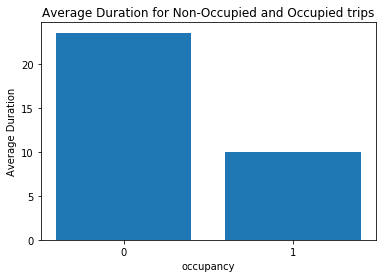

In [0]:
plot_duration = aggregated_data.groupby('occupancy')['duration'].mean()
plt.bar(plot_duration.index, plot_duration.values)
plt.xticks(plot_duration.index)
plt.title("Average Duration for Non-Occupied and Occupied trips")
plt.xlabel('occupancy')
plt.ylabel('Average Duration')
plt.show();

We can see that average distance is greater for occupied trips.

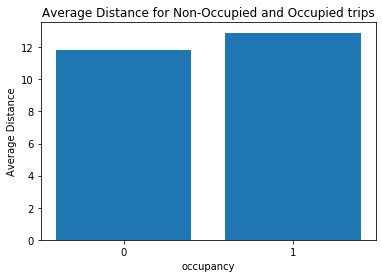

In [0]:
plot_distance = aggregated_data.groupby('occupancy')['distance'].mean()
plt.bar(plot_distance.index, plot_distance.values)
plt.xticks(plot_distance.index)
plt.title("Average Distance for Non-Occupied and Occupied trips")
plt.xlabel('occupancy')
plt.ylabel('Average Distance')
plt.show();

In [0]:
aggregated_data['duration'].describe()

count    8593.000000
mean       16.755468
std       114.428873
min         0.000000
25%         3.433333
50%         7.516667
75%        13.716667
max      6818.983333
Name: duration, dtype: float64

From boxplot we can see that the duration is not normally distributed

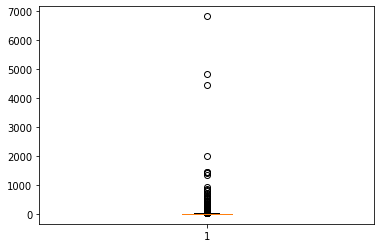

In [0]:
plt.boxplot(aggregated_data['duration']);

Pick-up Longitude and Latitude of San Francisco

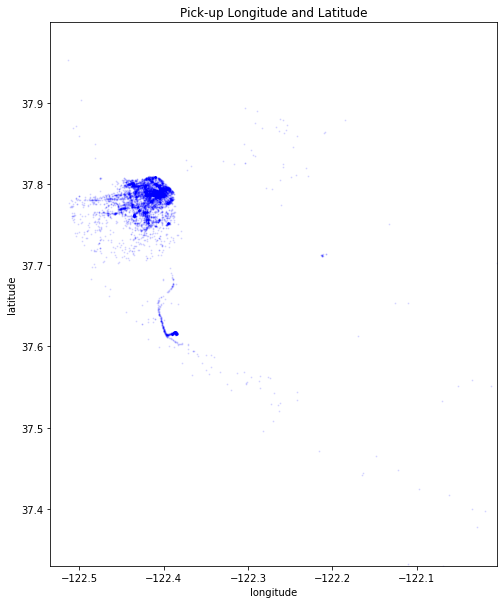

In [0]:
city_long_border = (aggregated_data['start_longitude'].min(), aggregated_data['start_longitude'].max())
city_lat_border = (aggregated_data['start_latitude'].min(), aggregated_data['start_latitude'].max())
plt.figure(figsize=(8,10))
plt.scatter(aggregated_data['start_longitude'].values, aggregated_data['start_latitude'].values,
              color='blue', s=1, alpha=0.1)
plt.title('Pick-up Longitude and Latitude')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [0]:
aggregated_data

,taxi_id,distance,duration,start_longitude,start_latitude,end_longitude,end_latitude,occupancy,start_time,end_time,No. of Waypoints,emission
trip_id,,,,,,,,,,,,
000a7016-95c0-4a6f-afbd-4eb6a0e0f4e3,new_abgibo,0.543472,3.750000,-122.44625,37.79566,-122.44964,37.79824,0,2008-05-21 00:18:05,2008-05-21 00:21:50,6,136.348394
001403cc-e3ca-4b79-91d2-ecf59f160905,new_abdremlu,22.396868,24.266667,-122.39922,37.61946,-122.42014,37.80612,1,2008-05-22 20:58:38,2008-05-22 21:22:54,26,5619.015910
001b0894-cd7c-4de2-8b9e-65b230ca05de,new_abdremlu,5.189942,15.133333,-122.42340,37.79338,-122.39837,37.77192,1,2008-05-22 23:21:56,2008-05-22 23:37:04,16,1302.073443
0021089d-39f0-47df-a99c-7b47b9442d7c,new_udwadla,1.116952,3.800000,-122.43212,37.79689,-122.42184,37.79624,0,2008-06-02 23:36:46,2008-06-02 23:40:34,6,280.225466
00363a3a-2962-4b70-a7a6-f5011d954bbd,new_abgibo,1.986649,5.666667,-122.40230,37.76155,-122.39509,37.75129,0,2008-06-06 08:01:46,2008-06-06 08:07:26,7,498.418399
...,...,...,...,...,...,...,...,...,...,...,...,...
ffdcecfb-3548-4ec0-ad63-684c0783afa8,new_abboip,12.967335,26.666667,-122.48292,37.70092,-122.41833,37.74806,0,2008-05-20 04:58:04,2008-05-20 05:24:44,31,3253.296788
ffddf206-e3e2-40ee-833b-757dfeb0cc19,new_abgibo,0.209796,0.966667,-122.39661,37.77578,-122.39488,37.77708,0,2008-05-18 22:12:49,2008-05-18 22:13:47,2,52.634487
ffe2f489-083f-434c-85fd-5ea34f1caadb,new_abdremlu,3.567260,7.150000,-122.43506,37.80090,-122.40029,37.79514,1,2008-06-05 12:11:21,2008-06-05 12:18:30,9,894.968466


Instead of using the actual next pickup location of the taxi as independent variable one can use the nearest pickup location (can be the pickup location of other taxi) within a specified time bin.

### Missing values

Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

Here, we are in the fortunate position that our data is complete and there are no missing values:

In [0]:
print(data.isnull().sum())

latitude     0
longitude    0
occupancy    0
time         0
taxi_id      0
trip_id      0
dtype: int64


### Feature Addition

In [0]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [0]:
def add_datetime_features(df, date_time_column):
    #Convert to datetime format
    
    df['hour'] = df[date_time_column].dt.hour
    df['day'] = df[date_time_column].dt.day
    df['weekday'] = df[date_time_column].dt.weekday
    
    return df

df = add_datetime_features(aggregated_data, 'start_time')

In [0]:
hour_bins = [-1, 5, 7, 10, 16, 21, 23]
bin_names = ['late_night', 'morning', 'morning_peak', 'afternoon', 'evening', 'night']
df['hour_type'] = pd.cut(df.hour, bins=hour_bins, labels=bin_names).cat.codes

In [0]:
df['speed'] = df['distance'] / (df['duration'] / 60) 

In [0]:
df.head()

,taxi_id,distance,duration,start_longitude,start_latitude,end_longitude,end_latitude,occupancy,start_time,end_time,No. of Waypoints,emission,hour,day,weekday,hour_type
trip_id,,,,,,,,,,,,,,,,
000a7016-95c0-4a6f-afbd-4eb6a0e0f4e3,new_abgibo,0.543472,3.750000,-122.44625,37.79566,-122.44964,37.79824,0,2008-05-21 00:18:05,2008-05-21 00:21:50,6,136.348394,0,21,2,0
001403cc-e3ca-4b79-91d2-ecf59f160905,new_abdremlu,22.396868,24.266667,-122.39922,37.61946,-122.42014,37.80612,1,2008-05-22 20:58:38,2008-05-22 21:22:54,26,5619.015910,20,22,3,4
001b0894-cd7c-4de2-8b9e-65b230ca05de,new_abdremlu,5.189942,15.133333,-122.42340,37.79338,-122.39837,37.77192,1,2008-05-22 23:21:56,2008-05-22 23:37:04,16,1302.073443,23,22,3,5
0021089d-39f0-47df-a99c-7b47b9442d7c,new_udwadla,1.116952,3.800000,-122.43212,37.79689,-122.42184,37.79624,0,2008-06-02 23:36:46,2008-06-02 23:40:34,6,280.225466,23,2,0,5
00363a3a-2962-4b70-a7a6-f5011d954bbd,new_abgibo,1.986649,5.666667,-122.40230,37.76155,-122.39509,37.75129,0,2008-06-06 08:01:46,2008-06-06 08:07:26,7,498.418399,8,6,4,2


#### Outlier removal



In [0]:
df = df[df['speed'] <= 300]

## Clustering

### K-means clustering

Determining the optimal number of clusters


In [0]:
coords = df[['start_latitude', 'start_longitude']].values

Silhouette score for different values of K

In [0]:
s_score = []
for i in range(2,40):
  km1 = MiniBatchKMeans(n_clusters=i, batch_size=1000 , random_state = 1).fit(coords)
  score = silhouette_score(X = coords, labels = km1.labels_)
  s_score = np.append(s_score, score)

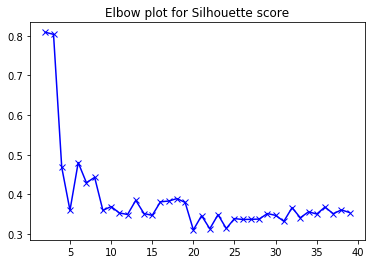

In [0]:
plt.plot(range(2,40), s_score, 'bx-')
plt.title('Elbow plot for Silhouette score');

We can choose 35 clusters for our task, since silhouette score is remaining the same after that cluster

In [0]:
kmeans = MiniBatchKMeans(n_clusters=35, batch_size=1000, random_state=1).fit(coords)
df['pickup_cluster'] = kmeans.predict(coords)

In [0]:
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

In [0]:
cluster_len

35

Map based on clusters

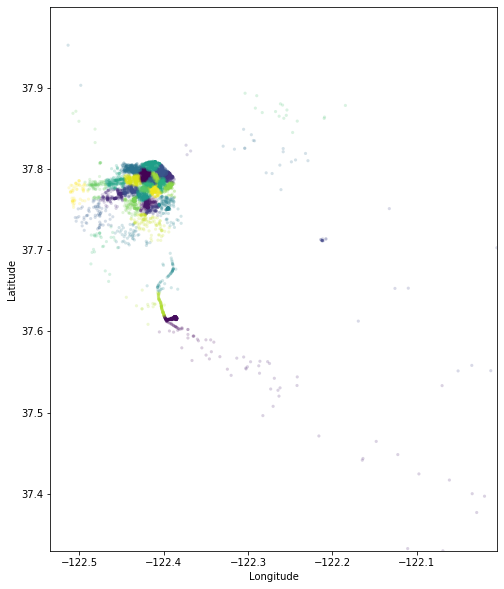

In [0]:
plt.figure(figsize=(8,10))
plt.scatter(df['start_longitude'].values, df['start_latitude'].values, s=10, lw=0,
           c=df['pickup_cluster'].values, alpha=0.2)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [0]:
# saving our result df to csv
# df.to_csv('/content/drive/My Drive/Colab Notebooks/data.csv')
# data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data.csv')
# data.head()

,trip_id,taxi_id,distance,duration,start_longitude,start_latitude,end_longitude,end_latitude,occupancy,start_time,end_time,No. of Waypoints,emission,hour,day,weekday,hour_type,pickup_cluster
0,000a7016-95c0-4a6f-afbd-4eb6a0e0f4e3,new_abgibo,0.543472,3.750000,-122.44625,37.79566,-122.44964,37.79824,0,2008-05-21 00:18:05,2008-05-21 00:21:50,6,136.348394,0,21,2,0,13
1,001403cc-e3ca-4b79-91d2-ecf59f160905,new_abdremlu,22.396868,24.266667,-122.39922,37.61946,-122.42014,37.80612,1,2008-05-22 20:58:38,2008-05-22 21:22:54,26,5619.015910,20,22,3,4,30
2,001b0894-cd7c-4de2-8b9e-65b230ca05de,new_abdremlu,5.189942,15.133333,-122.42340,37.79338,-122.39837,37.77192,1,2008-05-22 23:21:56,2008-05-22 23:37:04,16,1302.073443,23,22,3,5,0
3,0021089d-39f0-47df-a99c-7b47b9442d7c,new_udwadla,1.116952,3.800000,-122.43212,37.79689,-122.42184,37.79624,0,2008-06-02 23:36:46,2008-06-02 23:40:34,6,280.225466,23,2,0,5,13
4,00363a3a-2962-4b70-a7a6-f5011d954bbd,new_abgibo,1.986649,5.666667,-122.40230,37.76155,-122.39509,37.75129,0,2008-06-06 08:01:46,2008-06-06 08:07:26,7,498.418399,8,6,4,2,15


## Modeling

### Multivariate Regression and XGBoost

In [0]:
df.head()

,taxi_id,distance,duration,start_longitude,start_latitude,end_longitude,end_latitude,occupancy,start_time,end_time,No. of Waypoints,emission,hour,day,weekday,hour_type,pickup_cluster
trip_id,,,,,,,,,,,,,,,,,
000a7016-95c0-4a6f-afbd-4eb6a0e0f4e3,new_abgibo,0.543472,3.750000,-122.44625,37.79566,-122.44964,37.79824,0,2008-05-21 00:18:05,2008-05-21 00:21:50,6,136.348394,0,21,2,0,13
001403cc-e3ca-4b79-91d2-ecf59f160905,new_abdremlu,22.396868,24.266667,-122.39922,37.61946,-122.42014,37.80612,1,2008-05-22 20:58:38,2008-05-22 21:22:54,26,5619.015910,20,22,3,4,30
001b0894-cd7c-4de2-8b9e-65b230ca05de,new_abdremlu,5.189942,15.133333,-122.42340,37.79338,-122.39837,37.77192,1,2008-05-22 23:21:56,2008-05-22 23:37:04,16,1302.073443,23,22,3,5,0
0021089d-39f0-47df-a99c-7b47b9442d7c,new_udwadla,1.116952,3.800000,-122.43212,37.79689,-122.42184,37.79624,0,2008-06-02 23:36:46,2008-06-02 23:40:34,6,280.225466,23,2,0,5,13
00363a3a-2962-4b70-a7a6-f5011d954bbd,new_abgibo,1.986649,5.666667,-122.40230,37.76155,-122.39509,37.75129,0,2008-06-06 08:01:46,2008-06-06 08:07:26,7,498.418399,8,6,4,2,15


Defining target variables(pick-up latitude and pick-up longitude) and features. We have two target variables, it means we need to do multivariate analysis.

In [0]:
X = df[['distance', 'duration', 'end_longitude', 'end_latitude', 'occupancy', 'hour', 'day', 'weekday', 'hour_type', 'pickup_cluster']]
Y = df[['start_longitude', 'start_latitude']]

In [0]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

#### Multivariate XgBoost

In [0]:
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:linear'))
multioutputregressor.fit(X_train, y_train)
y_pred_xg = multioutputregressor.predict(X_test)

[17:16:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbos

In [0]:
mean_squared_error(y_test, y_pred_xg)

0.0003338297535602484

##### Feature Importance for 2 estimators

In [0]:
importance_longitude = multioutputregressor.estimators_[0].feature_importances_
importance_latitude = multioutputregressor.estimators_[1].feature_importances_

###### Feature Importance for Longitude

Feature ranking:
pickup_cluster: 0.21243558824062347
occupancy: 0.2054966241121292
distance: 0.1660332828760147
duration: 0.15832246840000153
end_longitude: 0.13817636668682098
end_latitude: 0.11943280696868896
weekday: 0.00010292112710885704
hour_type: 0.0
day: 0.0
hour: 0.0


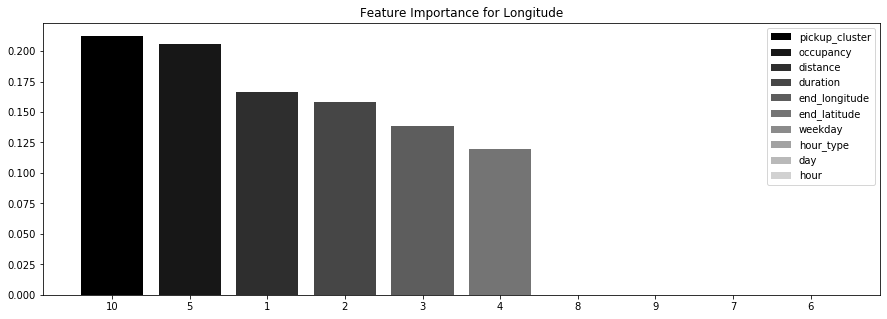

In [0]:
indices = np.argsort(importance_longitude)[::-1]
# Plot the feature importancies of the multivariate xgBoost
num_to_plot = X.columns.shape[0]
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print(f"{X.columns[feature_indices[f]-1]}: {importance_longitude[indices[f]]}")
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance for Longitude")
bars = plt.bar(range(num_to_plot), 
               importance_longitude[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
# plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(X.columns[i-1]) 
                  for i in feature_indices]);

###### Feature Importance for Latitude

Feature ranking:
end_latitude: 0.4291689097881317
pickup_cluster: 0.26370570063591003
distance: 0.13900373876094818
duration: 0.07614041119813919
occupancy: 0.057326480746269226
end_longitude: 0.03279740363359451
hour: 0.0018573628040030599
hour_type: 0.0
weekday: 0.0
day: 0.0


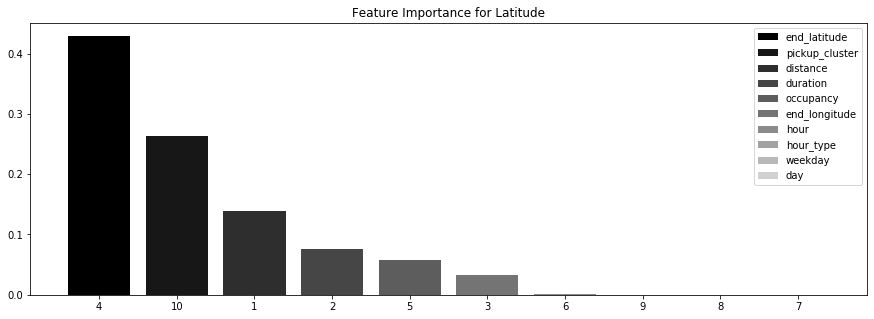

In [0]:
indices = np.argsort(importance_latitude)[::-1]
# Plot the feature importancies of the multivariate xgBoost
num_to_plot = X.columns.shape[0]
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print(f"{X.columns[feature_indices[f]-1]}: {importance_latitude[indices[f]]}")
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance for Latitude")
bars = plt.bar(range(num_to_plot), 
               importance_latitude[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
# plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(X.columns[i-1]) 
                  for i in feature_indices]);

#### Multivariate Linear Regression

In [0]:
multioutput_lr = MultiOutputRegressor(LinearRegression())
multioutput_lr.fit(X_train, y_train)
y_pred_lr = multioutput_lr.predict(X_test)
print('Mean squared error', mean_squared_error(y_test, y_pred_lr))

Mean squared error 0.0012672351742889988


Coefficients for 2 target variables

In [0]:
multioutput_lr.estimators_[0].coef_

array([ 2.35834176e-05, -1.66288974e-06,  3.00185753e-01, -3.58412563e-02,
       -3.77689026e-03,  3.72960146e-04, -9.29015932e-05, -3.62455733e-04,
       -1.23901020e-03, -3.02368967e-04])

In [0]:
multioutput_lr.estimators_[1].coef_

array([-7.14840611e-05,  5.09423154e-07, -4.57151965e-02,  3.63109032e-01,
        1.29725092e-03, -6.61647820e-04,  1.25341118e-04,  3.12256380e-04,
        1.63903130e-03,  7.35838617e-04])

### Time Series prediction Model (in devolopment)

Given a region and a 10 min interval, we have to predict pickups.

(a): How to break up the San Francisco into regions?

(b): Every region of San Francisco has to be broken up into 10 min interval.

Now, every row pickup has longitude and latitude in it, and we will use this to define pickup regions.
We already know, about the pickup at time ‘t’, we will predict the pickup at time ‘t+1’ in the same region. Hence, this problem can be thought of as a ‘*Time Series Prediction*’ problem. It is a special case of regression problems. In short, we will use the data at time ‘t’ to predict for time ‘t+1’.